In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import umap

def track_lineages(mst_graph, start_clusters):
    valid_paths = []
    node_coverage = set()
    node_degree = {node: mst_graph.degree(node) for node in mst_graph.nodes}
    
    for start in start_clusters:
        queue = [(start, [start], None)]
        
        while queue:
            current_node, path, parent_node = queue.pop(0)
            neighbors = [n for n in mst_graph.neighbors(current_node) if n != parent_node]
            
            if node_degree[current_node] == 1 and current_node != start:
                valid_paths.append(path.copy())
                node_coverage.update(path)
                continue
            
            for neighbor in neighbors:
                if neighbor in start_clusters and neighbor != start:
                    continue
                new_path = path + [neighbor]
                queue.append((neighbor, new_path, current_node))
    
    all_nodes = set(mst_graph.nodes)
    if node_coverage != all_nodes:
        uncovered = all_nodes - node_coverage
  
    
    lineages = []
    for i, path in enumerate(valid_paths):
        lineage = {
            "id": f"lineage_{i}",
            "start": path[0],
            "path": path,
            "split_points": [node for node in path[1:-1] if node_degree[node] >= 3]
        }
        lineages.append(lineage)
    
    return lineages

def merge_lineage_starts(lineages, start_clusters):
    path_groups = {}
    for lineage in lineages:
        non_start_path = tuple(lineage['path'][1:])
        if non_start_path not in path_groups:
            path_groups[non_start_path] = []
        path_groups[non_start_path].append(lineage)
    
    merged_lineages = []
    for non_start_path, group in path_groups.items():
        starts = [lineage['start'] for lineage in group] 
        merged_lineage = {
            "id": f"merged_lineage_{len(merged_lineages)}",
            "start": "Merged Start",  
            "original_starts": starts, 
            "path": ["Merged Start"] + list(non_start_path),
            "split_points": group[0]['split_points'],
            "original_lineages": [lineage['id'] for lineage in group]
        }
        merged_lineages.append(merged_lineage)
    
    return merged_lineages

def visualize_merged_lineages(adata, mst_edges_df, lineages, merged_lineages, start_clusters, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 12))
    
    umap_coords = adata.obsm['X_umap']
    cluster_labels = adata.obs['Region']
    umap_cluster_centers = pd.DataFrame(umap_coords, index=cluster_labels.index).groupby(cluster_labels, observed=True).median()
    
  
    start_centers = umap_cluster_centers.loc[start_clusters]
    merged_center = start_centers.mean()
    merged_x, merged_y = merged_center[0], merged_center[1]

    sc.pl.umap(adata, color='Region', ax=ax, show=False, legend_loc='on data',
               size=50, frameon=False, legend_fontsize='large', legend_fontoutline=2)

    for _, row in mst_edges_df.iterrows():
        start, end = row['from'], row['to']
        if start in umap_cluster_centers.index and end in umap_cluster_centers.index:
            x = [umap_cluster_centers.loc[start, 0], umap_cluster_centers.loc[end, 0]]
            y = [umap_cluster_centers.loc[start, 1], umap_cluster_centers.loc[end, 1]]
            ax.plot(x, y, color='#cccccc', linewidth=1.0, zorder=1)
    

    ax.scatter(merged_x, merged_y, s=300, color='red', edgecolor='white', zorder=5, marker='*')
    ax.text(merged_x + 0.5, merged_y + 0.2, 'Merged Start', fontsize=12, fontweight='bold', color='red')
    
    for cluster in start_clusters:
        x, y = umap_cluster_centers.loc[cluster, [0, 1]]
        ax.scatter(x, y, s=150, color='red', alpha=0.6, edgecolor='white', zorder=4, marker='o')
        ax.text(x + 0.3, y + 0.1, cluster, fontsize=9, color='red')
    

    lineage_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 
                     'pink', 'gray', 'olive', 'cyan', 'teal', 'maroon']
    

    for i, merged_lineage in enumerate(merged_lineages):
        color_idx = i % len(lineage_colors)
        path = merged_lineage['path']

        if len(path) >= 2:
            first_node = path[1]
            if first_node in umap_cluster_centers.index:
                x = [merged_x, umap_cluster_centers.loc[first_node, 0]]
                y = [merged_y, umap_cluster_centers.loc[first_node, 1]]
                ax.plot(x, y, color=lineage_colors[color_idx], linewidth=2.5, zorder=3)

        for j in range(1, len(path) - 1):
            start_node = path[j]
            end_node = path[j+1]
            if start_node in umap_cluster_centers.index and end_node in umap_cluster_centers.index:
                x = [umap_cluster_centers.loc[start_node, 0], umap_cluster_centers.loc[end_node, 0]]
                y = [umap_cluster_centers.loc[start_node, 1], umap_cluster_centers.loc[end_node, 1]]
                ax.plot(x, y, color=lineage_colors[color_idx], linewidth=2.5, zorder=3)

    for i, lineage in enumerate(lineages):
        color_idx = i % len(lineage_colors)
        path = lineage['path']
        for j in range(len(path) - 1):
            start_node = path[j]
            end_node = path[j+1]
            if start_node in umap_cluster_centers.index and end_node in umap_cluster_centers.index:
                x = [umap_cluster_centers.loc[start_node, 0], umap_cluster_centers.loc[end_node, 0]]
                y = [umap_cluster_centers.loc[start_node, 1], umap_cluster_centers.loc[end_node, 1]]
                ax.plot(x, y, color=lineage_colors[color_idx], linewidth=1.5, zorder=2, linestyle='--', alpha=0.7)
    

    split_points = set()
    for lineage in merged_lineages:
        split_points.update(lineage['split_points'])
    
    for node in split_points:
        if node in umap_cluster_centers.index and node not in start_clusters:
            x, y = umap_cluster_centers.loc[node, [0, 1]]
            ax.scatter(x, y, s=120, color='blue', edgecolor='white', zorder=4, marker='^')
            ax.text(x + 0.3, y + 0.1, f'Split: {node}', fontsize=9, color='blue')
    

    for i, lineage in enumerate(merged_lineages):
        ax.plot([], [], color=lineage_colors[i % len(lineage_colors)], linewidth=2.5, 
                label=f"Lineage {i+1} (Original: {', '.join(lineage['original_starts'])})")
    
    ax.plot([], [], color='black', linestyle='-', linewidth=2.5, label='Merged Path')
    ax.plot([], [], color='black', linestyle='--', linewidth=1.5, label='Original Path')
    
    ax.legend(loc='upper right', frameon=True, fontsize=10)
    ax.set_title("Lineage Tracking with Merged Start", fontsize=16)
    
    return ax


import random
import torch
def setup_seed(seed: int = 42, deterministic: bool = False):

    random.seed(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False  


c:\Users\Ivan1\anaconda3\envs\sb\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data...


c:\Users\Ivan1\anaconda3\envs\sb\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Original start clusters: ['WM']
Building MST...
Tracking original lineages...
Merging lineages...
Visualizing results...


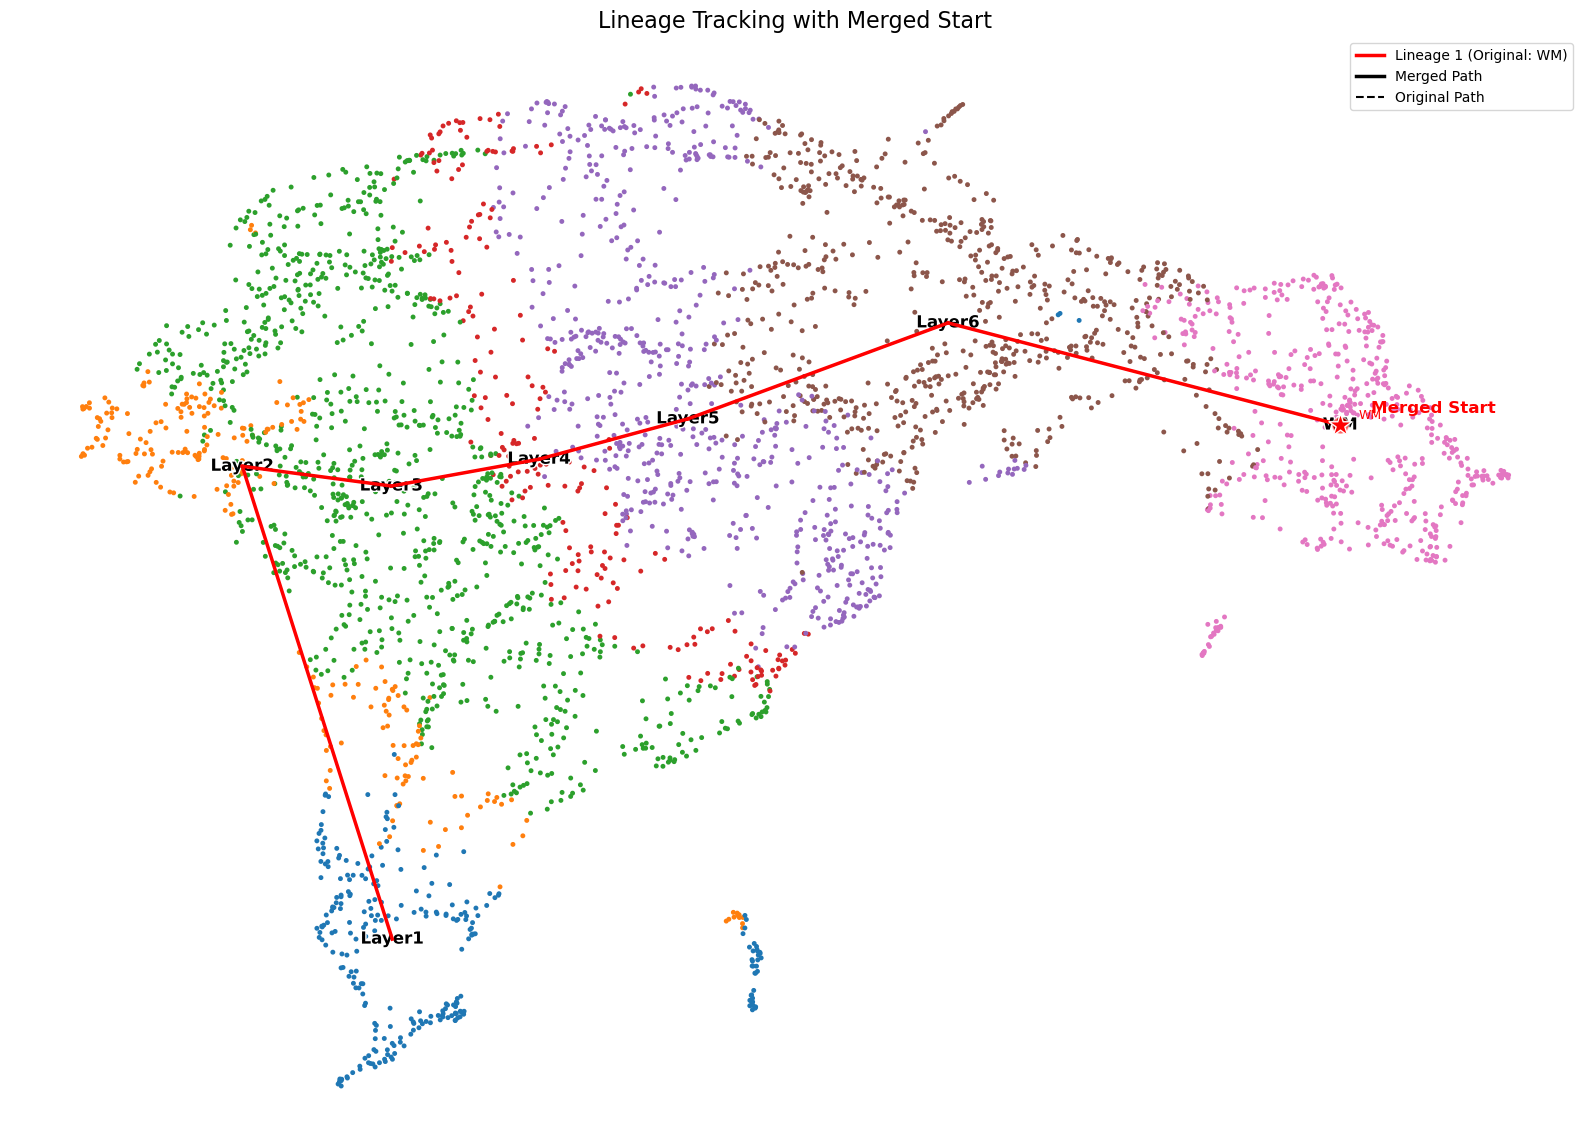

In [ ]:
seed = 42
setup_seed(seed=seed)

print("Loading data...")
dirs="Data/2.6/"
adata=sc.read_h5ad(dirs+'STAGATE_Result_151673.h5ad')

mapper = umap.UMAP(n_neighbors=15, min_dist=0.3, n_components=2, random_state=seed)


embedding = mapper.fit_transform(adata.obsm['STAGATE'])

adata.obsm['X_umap'] = embedding


start_clusters = ['WM']
print(f"Original start clusters: {start_clusters}")


print("Building MST...")
pca_coords = adata.obsm['X_pca']
cluster_labels = adata.obs['Region']
pca_centers = pd.DataFrame(pca_coords, index=cluster_labels.index).groupby(cluster_labels, observed=True).median()
cluster_names = pca_centers.index.tolist()

dist_mat = distance_matrix(pca_centers.values, pca_centers.values)
mst = minimum_spanning_tree(dist_mat)
mst_array = mst.toarray()

edges = []
for i in range(len(cluster_names)):
    for j in range(i+1, len(cluster_names)):
        if mst_array[i, j] > 1e-6:
            edges.append({'from': cluster_names[i], 'to': cluster_names[j], 'weight': mst_array[i, j]})
mst_edges_df = pd.DataFrame(edges)

G = nx.Graph()
for _, row in mst_edges_df.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['weight'])


print("Tracking original lineages...")
lineages = track_lineages(G, start_clusters)


print("Merging lineages...")
merged_lineages = merge_lineage_starts(lineages, start_clusters)
adata.obs['merged_clusters'] = adata.obs['Region'].apply(lambda x: x if x not in start_clusters else 'Merged Start')


print("Visualizing results...")
fig, ax = plt.subplots(figsize=(16, 12))
ax = visualize_merged_lineages(adata, mst_edges_df, lineages, merged_lineages, start_clusters, ax=ax)
ax.set_aspect('equal', adjustable='box') 
plt.tight_layout()
plt.savefig(
    './paul15_results/merged_lineages.pdf', 
    format='pdf',
    dpi=300,                
    bbox_inches='tight',    
    pad_inches=0.1          
)
plt.show()

In [3]:
merged_lineages 

[{'id': 'merged_lineage_0',
  'start': 'Merged Start',
  'original_starts': ['WM'],
  'path': ['Merged Start',
   'Layer6',
   'Layer5',
   'Layer4',
   'Layer3',
   'Layer2',
   'Layer1'],
  'split_points': [],
  'original_lineages': ['lineage_0']}]

In [4]:

max_len = max(len(l['path']) for l in merged_lineages)


padded_lineages = []
for lineage in merged_lineages:
    original_path = lineage['path']
    current_len = len(original_path)
    

    if current_len < max_len:
        last_node = original_path[-1]
        padding = [last_node] * (max_len - current_len)
        padded_path = original_path + padding
    else:
        padded_path = original_path

    new_lineage_entry = lineage.copy()
    new_lineage_entry['path'] = padded_path
    padded_lineages.append(new_lineage_entry)

for i, lineage in enumerate(padded_lineages):
    print(f"谱系 {i+1}: {' → '.join(lineage['path'])}")
print("-" * 30)


time_cluster_to_id = {}
unique_clusters_per_time = [sorted(list(set(l['path'][t] for l in padded_lineages))) for t in range(max_len)]

for t, clusters_at_t in enumerate(unique_clusters_per_time):
    for i, cluster_name in enumerate(clusters_at_t):
        time_cluster_to_id[(t, cluster_name)] = i


for i, (key, value) in enumerate(time_cluster_to_id.items()):
    print(f"{key}: {value}")


encoded_edges_set = set()
for lineage in padded_lineages:
    path = lineage['path']
    for t in range(max_len - 1):
        parent_node_name = path[t]
        child_node_name = path[t+1]
        
        parent_id = time_cluster_to_id[(t, parent_node_name)]
        child_id = time_cluster_to_id[(t+1, child_node_name)]
        
        parent_tuple = (t, parent_id)
        child_tuple = (t+1, child_id)
        
        edge = (parent_tuple, child_tuple, 1, 'backbone')
        encoded_edges_set.add(edge)

final_edges = sorted(list(encoded_edges_set))





adata_by_stage = []
for t in range(max_len):
    clusters_at_t = unique_clusters_per_time[t]
    
    if t == 0 and 'Merged Start' in clusters_at_t:
        stage_adata = adata[adata.obs['merged_clusters'] == 'Merged Start'].copy()
    else:
        stage_adata = adata[adata.obs['Region'].isin(clusters_at_t)].copy()
        
    adata_by_stage.append(stage_adata)
    


谱系 1: Merged Start → Layer6 → Layer5 → Layer4 → Layer3 → Layer2 → Layer1
------------------------------
(0, 'Merged Start'): 0
(1, 'Layer6'): 0
(2, 'Layer5'): 0
(3, 'Layer4'): 0
(4, 'Layer3'): 0
(5, 'Layer2'): 0
(6, 'Layer1'): 0


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scope import computations as cmp
from scope import clustering as cl
from scope import pre_match as pm
from scope import visualizations as vi

In [6]:
data_lst = [torch.Tensor(data.obsm['STAGATE']) for data in adata_by_stage]
label_list_for_train = [
    torch.LongTensor(
        (d.obs['merged_clusters'] if t == 0 else d.obs['Region'])
        .map(lambda cluster_name: time_cluster_to_id[(t, cluster_name)])
        .values
    ) 
    for t, d in enumerate(adata_by_stage)
]
time_steps = list(range(len(data_lst)))
meta=[[time_steps[i]]*len(data_lst[i]) for i in range(len(time_steps))]
meta=np.concatenate(meta)

max_variance_differences = cmp.max_adjacent_covariance_diagonal_differences([cells for cells in data_lst])
print(max_variance_differences)
eps_func = cmp.piecewise_eps_function(time_steps, max_variance_differences,snr=0.95,min_eps=0.1) 

[2.554625988006592, 3.7890501022338867, 0.41182488203048706, 0.5352423787117004, 1.4369639158248901, 1.3907687664031982]


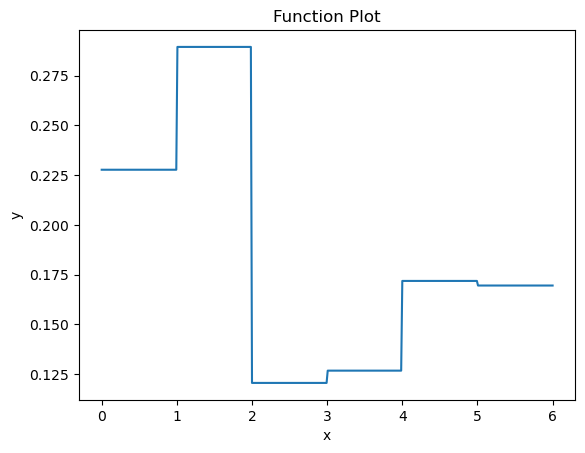

In [7]:
x = np.linspace(time_steps[0], time_steps[-1], 400)

y = [eps_func(x_i) for x_i in x]

plt.plot(x, y)

plt.title('Function Plot')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [8]:
import scope
from scope import model

steps_each_day = 32
steps = (len(time_steps)-1)*steps_each_day
# eps = lambda t: np.exp(0.1 * t) 
eps = eps_func
eps_test = eps
sb_object=model.sb_muti_model(data_lst,time_steps,N_pretraining=4000,N_finetuning=4000,backbone_lr=1e-3,finetuning_lr=1e-3,hiden_size=128,n_layers=4,
                              steps=steps,eps=eps,early_stop=False,patience=32,B=128,lambda_=0,save=True,record_gap=10,save_path='model_history/DLPFC',
                              prematched=True, label_list=label_list_for_train, edges=final_edges, weighting_strategy='enos', beta=0.9)

INFO: 从演化图中找到了 1 条长度为 7 的有效路径（演化蓝图）。
defaultdict(<class 'float'>, {0: 1.0})


In [9]:
#sb_object.backbone_train()
sb_object.backbone_load('model_history/DLPFC/backbone.pt')
fore_base=sb_object.eval_fore(torch.tensor(data_lst[0]).repeat(1,1).double(),sb_object.v_fore)

c:\Users\Ivan1\Desktop\dlpfc\SCOPE_CODE\scope\model.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models_dict=torch.load(model_path)
C:\Users\Ivan1\AppData\Local\Tem

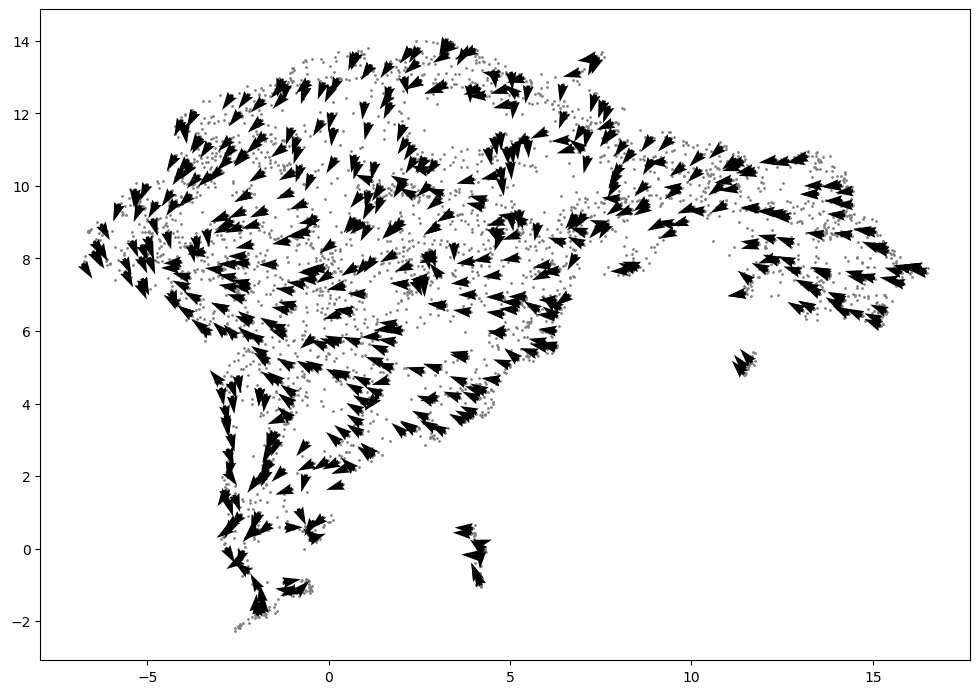

In [10]:
vi.visualize_drift_func([d.cuda() for d in data_lst],np.concatenate(data_lst),sb_object,meta,umap_model=mapper,save_path='./paul15_results/drift_backbone',xg_lower_bound=-10,xg_upper_bound=20,yg_lower_bound=-3,yg_upper_bound=15,adjust_equal=True)

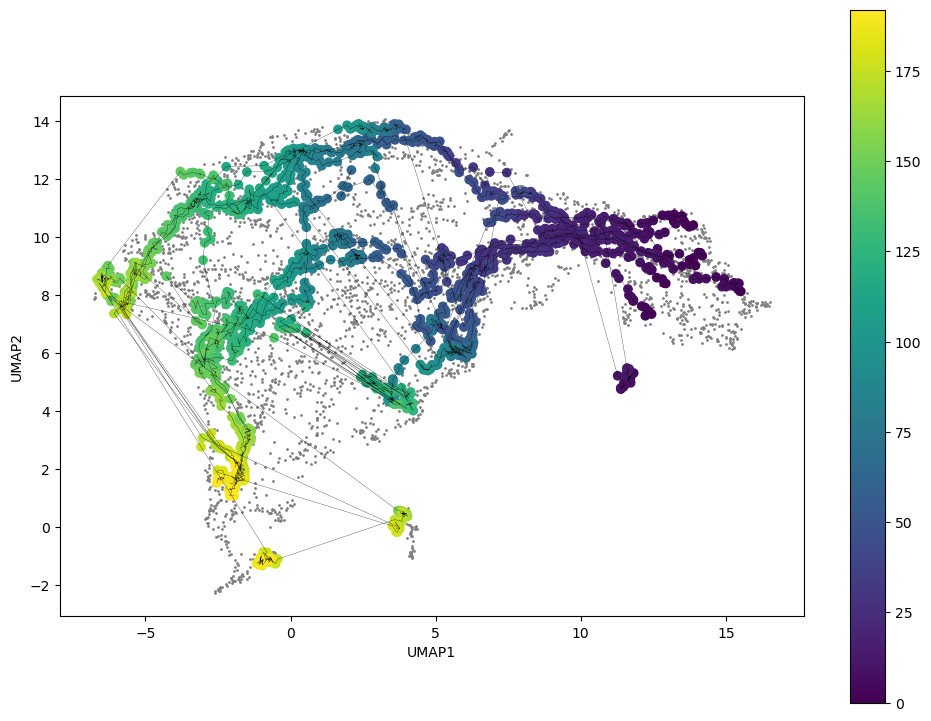

In [11]:
vi.visualize_generated_trajectories(data_lst,fore_base,umap_model=mapper,save_path='./paul15_results/generated_trajectories_backbone',adjust_equal=True,n_trajectories=10)

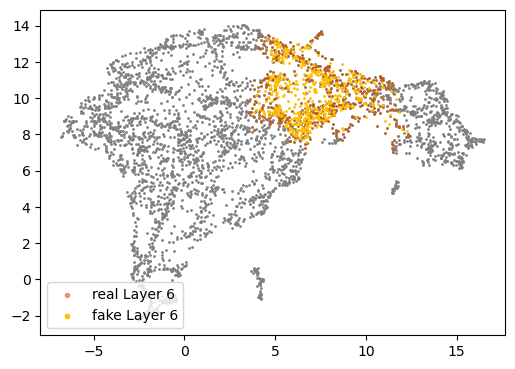

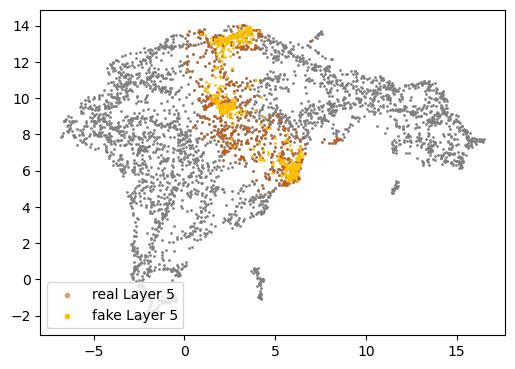

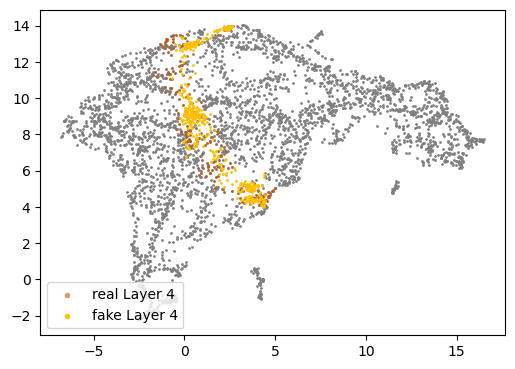

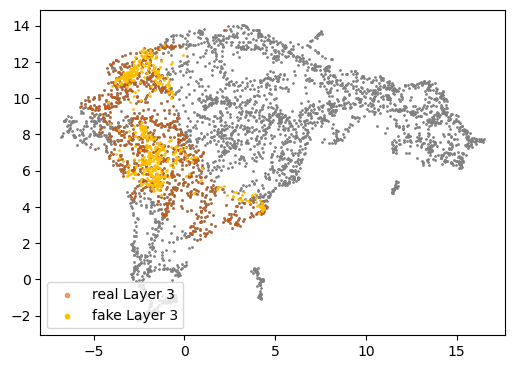

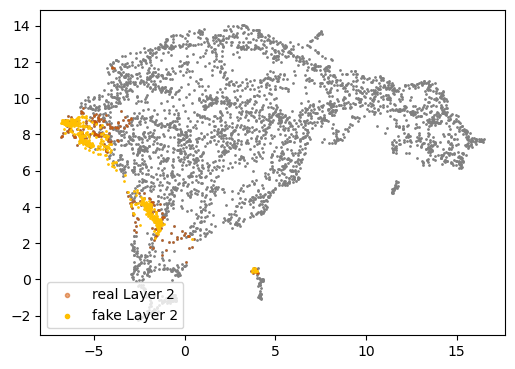

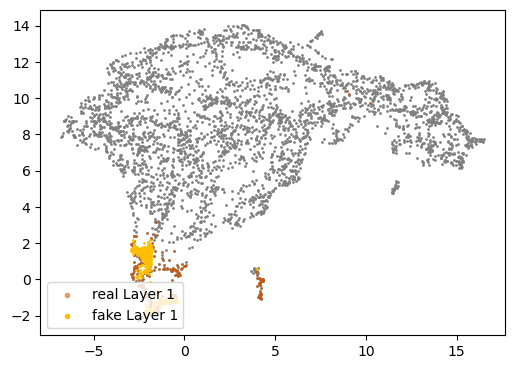

In [12]:
vi.visualize_generated_populations(data_lst,fore_base,time_steps,umap_model=mapper,save_path='./paul15_results/generated_populations_backbone',adjust_equal=True)

In [13]:
sb_object.finetuning_load('model_history/DLPFC/fine_tuned.pt')

c:\Users\Ivan1\Desktop\dlpfc\SCOPE_CODE\scope\model.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models_dict=torch.load(model_path)


In [14]:
fore_ft=sb_object.eval_fore(data_lst[0].double(),sb_object.v_fore_fine_tuned)

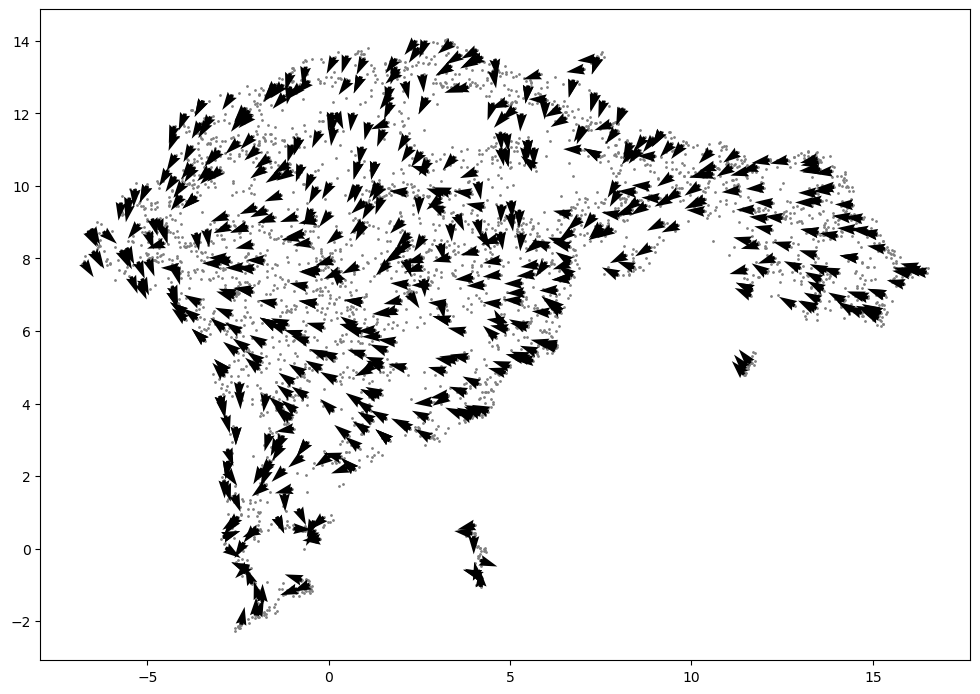

In [15]:
vi.visualize_drift_func([d.cuda() for d in data_lst],np.concatenate(data_lst),sb_object,meta,umap_model=mapper,save_path='./paul15_results/drift_fine_tuned',xg_lower_bound=-10,xg_upper_bound=20,yg_lower_bound=-3,yg_upper_bound=15,adjust_equal=True)

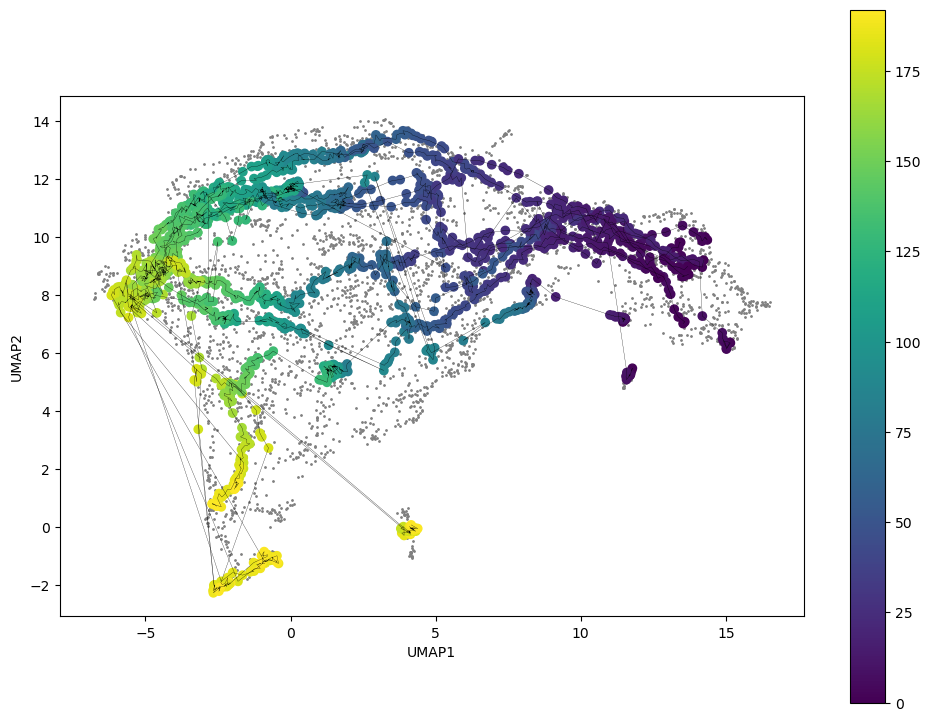

In [16]:
vi.visualize_generated_trajectories(data_lst,fore_ft,umap_model=mapper,save_path='./paul15_results/generated_trajectories_fine_tuned',adjust_equal=True,n_trajectories=10)

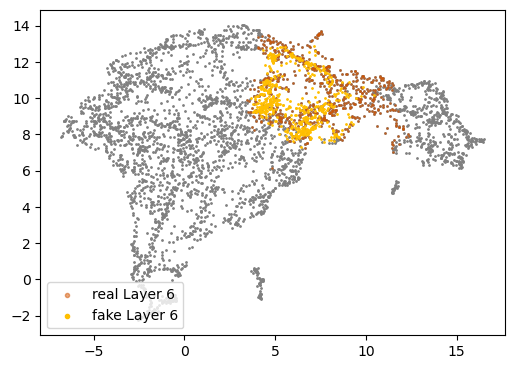

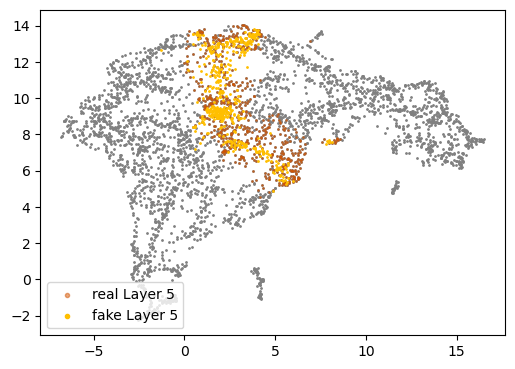

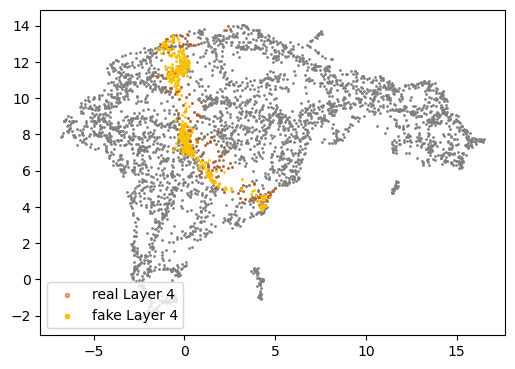

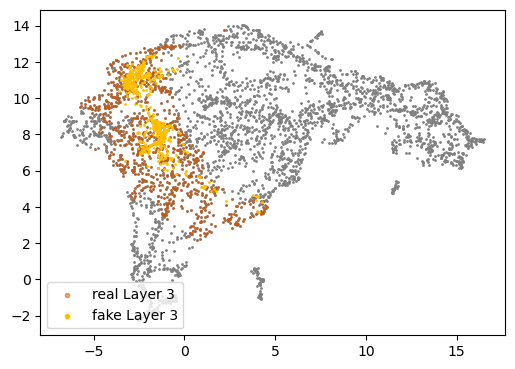

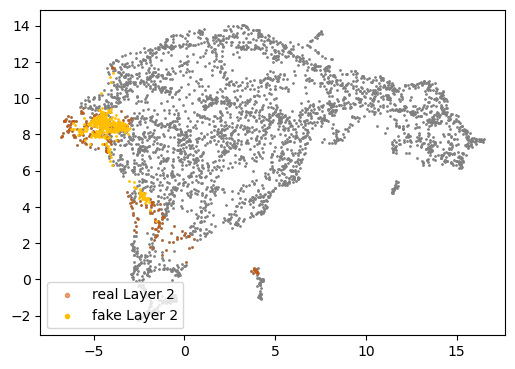

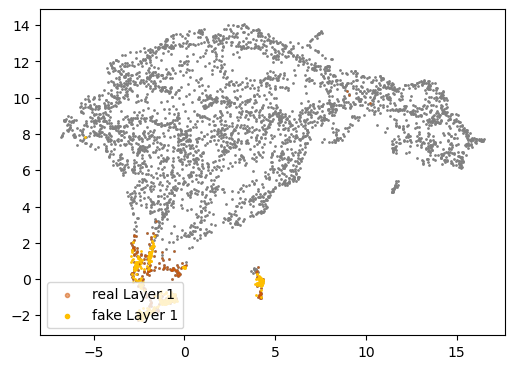

In [17]:
vi.visualize_generated_populations(data_lst,fore_ft,time_steps,umap_model=mapper,save_path='./paul15_results/generated_populations_fine_tuned',adjust_equal=True)

In [18]:
from geomloss import SamplesLoss
ot_solver = SamplesLoss("sinkhorn", p = 2, blur = 0.1, scaling = 0.7,backend='auto')

for week,data in enumerate(data_lst[1:]):
    data = torch.tensor(data, dtype=torch.float32).contiguous().cuda()
    back_bone_fake_data = torch.tensor(fore_base[time_steps[week+1]*steps_each_day], dtype=torch.float32).contiguous().cuda()
    print("backbone real" + str(time_steps[week+1]) + "-fake" + str(time_steps[week+1]),ot_solver(data, back_bone_fake_data).item())
    fine_tune_fake_data = torch.tensor(fore_ft[time_steps[week+1]*steps_each_day], dtype=torch.float32).contiguous().cuda()
    print("finetuned real" + str(time_steps[week+1]) + "-fake" + str(time_steps[week+1]),ot_solver(data, fine_tune_fake_data).item())

[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


C:\Users\Ivan1\AppData\Local\Temp\ipykernel_84248\3531887930.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).contiguous().cuda()
C:\Users\Ivan1\AppData\Local\Temp\ipykernel_84248\3531887930.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  back_bone_fake_data = torch.tensor(fore_base[time_steps[week+1]*steps_each_day], dtype=torch.float32).contiguous().cuda()
C:\Users\Ivan1\AppData\Local\Temp\ipykernel_84248\3531887930.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fine_tune_fake_d

backbone real1-fake1 4.546319961547852
finetuned real1-fake1 10.915950775146484
backbone real2-fake2 3.1766340732574463
finetuned real2-fake2 2.8894331455230713
backbone real3-fake3 3.2278032302856445
finetuned real3-fake3 2.6933515071868896
backbone real4-fake4 3.510406494140625
finetuned real4-fake4 4.062790870666504
backbone real5-fake5 4.671307563781738
finetuned real5-fake5 11.042427062988281
backbone real6-fake6 8.186931610107422
finetuned real6-fake6 8.2800874710083


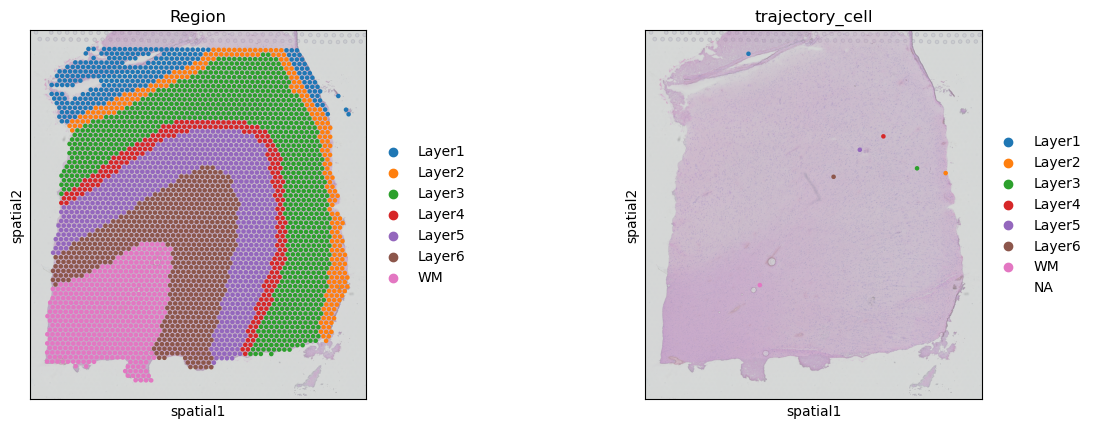

In [19]:
from sklearn.neighbors import NearestNeighbors
fore_cell=[fore_ft[i] for i in range(0, len(fore_ft), steps_each_day)]
adata.obs['trajectory_cell'] = None
trajectory_index = 2
selected_trajectory = [fore_cell[t][trajectory_index] for t in range(len(fore_cell))]
lineage_path = padded_lineages[0]['path'] 
for i, target_cell_features in enumerate(selected_trajectory):
    if i == 0:
        target_cluster = 'WM'
        original_adata_subset = adata[adata.obs['Region']==target_cluster].copy()
    else:
        target_cluster = lineage_path[i]
        original_adata_subset = adata[adata.obs['Region'] == target_cluster].copy()
    features_for_knn = original_adata_subset.obsm['STAGATE']
    knn = NearestNeighbors(n_neighbors=1, algorithm='auto')
    knn.fit(features_for_knn)
    
    # 寻找最近的细胞
    # 需要将目标细胞特征转换为 (1, n_features) 的形状
    distances, indices = knn.kneighbors(target_cell_features.reshape(1, -1))
    
    # 获取最接近细胞的 barcode (即 adata.obs 的索引)
    closest_cell_barcode = original_adata_subset.obs.index[indices[0]]
    adata.obs.loc[closest_cell_barcode, 'trajectory_cell'] = target_cluster
adata.obs['trajectory_cell'] = adata.obs['trajectory_cell'].astype('category')
sc.pl.spatial(
        adata,
        color=["Region", "trajectory_cell"],
        groups=['WM', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6'],
        alpha_img=0.5,
        spot_size=120  # 您可以根据需要调整此值
    )
plt.show()


--- Generating plot 1/5 for trajectory index: 427 ---


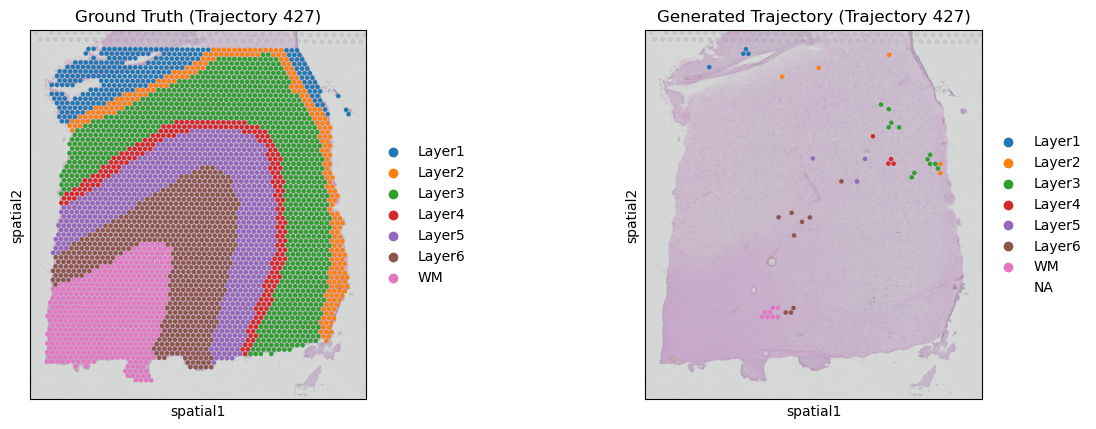

--- Generating plot 2/5 for trajectory index: 465 ---


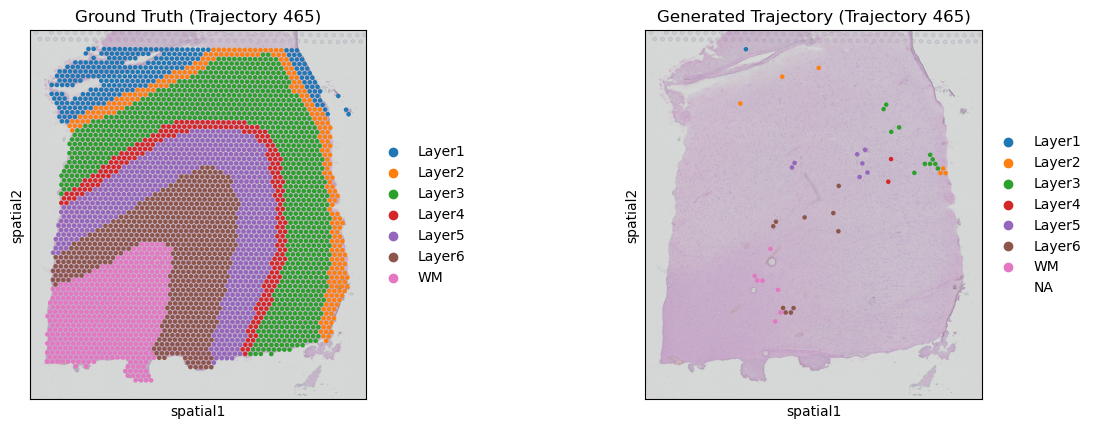

--- Generating plot 3/5 for trajectory index: 117 ---


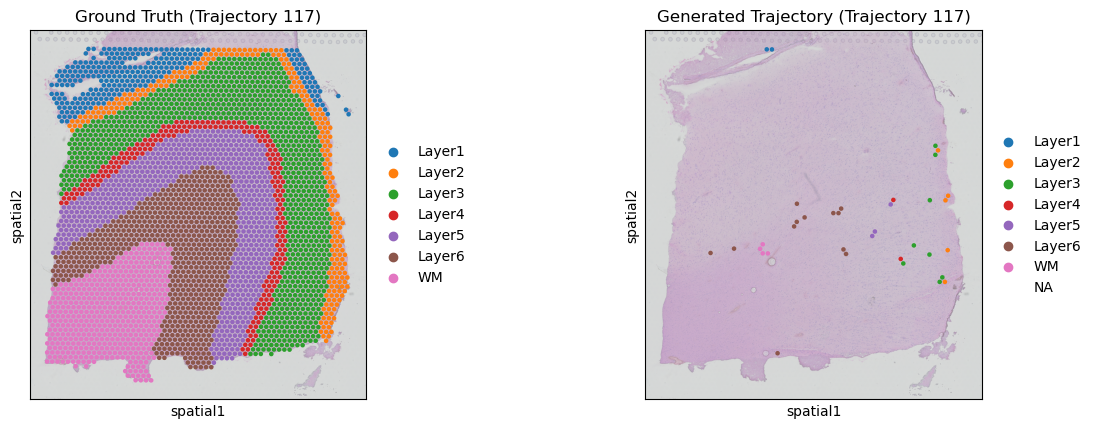

--- Generating plot 4/5 for trajectory index: 156 ---


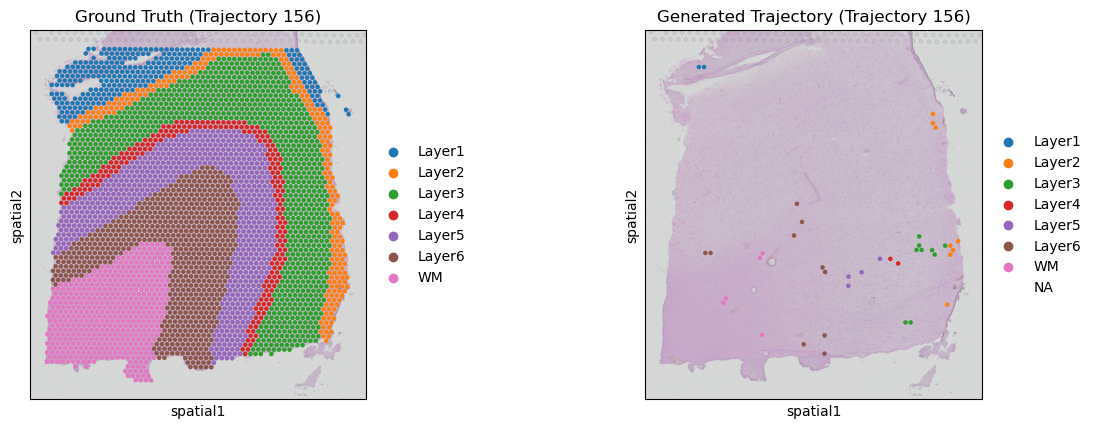

--- Generating plot 5/5 for trajectory index: 171 ---


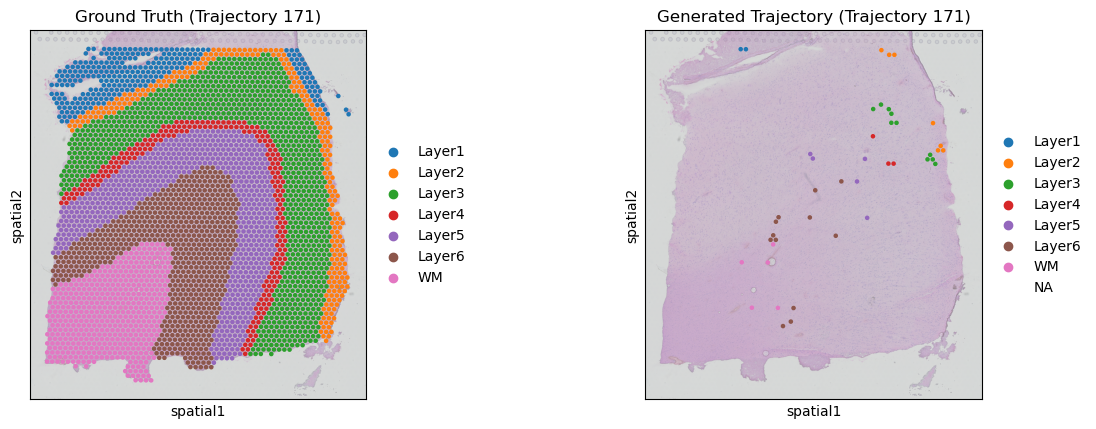

--- Finished. Saved 5 plots to './paul15_results' folder. ---


In [21]:
from sklearn.neighbors import NearestNeighbors
import os

# --- 设置 ---
# 定义要生成的随机轨迹图的数量
N = 5 
# 定义保存PDF的文件夹
output_dir = './paul15_results'
# 确保输出文件夹存在
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# --- 循环生成和保存图形 ---
for plot_num in range(N):
    # 每次循环都重置轨迹列
    adata.obs['trajectory_cell'] = None
    
    # 随机选择一条轨迹
    trajectory_index = np.random.randint(0, fore_ft[0].shape[0])
    print(f"--- Generating plot {plot_num + 1}/{N} for trajectory index: {trajectory_index} ---")
    
    selected_trajectory = [fore_ft[t][trajectory_index] for t in range(len(fore_ft))]
    lineage_path = padded_lineages[0]['path'] 

    # 遍历生成的轨迹中的每一个细胞
    for i, target_cell_features in enumerate(selected_trajectory):
        # 计算当前细胞在谱系路径中的位置
        j = i // steps_each_day
        
        # 确保 j 不会超出 lineage_path 的范围
        if j >= len(lineage_path) - 1:
            target_cluster = [lineage_path[-1]]
        else:
            target_cluster = [lineage_path[j], lineage_path[j+1]]

        # 'Merged Start' 对应于 'WM'
        if 'Merged Start' in target_cluster:
            target_cluster.remove('Merged Start')
            if 'WM' not in target_cluster:
                target_cluster.append('WM')
                
        original_adata_subset = adata[adata.obs['Region'].isin(target_cluster)].copy()
        
        if original_adata_subset.shape[0] == 0:
            continue

        features_for_knn = original_adata_subset.obsm['STAGATE']
        knn = NearestNeighbors(n_neighbors=1, algorithm='auto')
        knn.fit(features_for_knn)
        
        distances, indices = knn.kneighbors(target_cell_features.reshape(1, -1))
        
        closest_cell_barcode = original_adata_subset.obs.index[indices[0][0]]
        
        adata.obs.loc[closest_cell_barcode, 'trajectory_cell'] = adata.obs.loc[closest_cell_barcode, 'Region']

    # 转换数据类型以便绘图
    adata.obs['trajectory_cell'] = adata.obs['trajectory_cell'].astype('category')
    
    # 绘图
    sc.pl.spatial(
            adata,
            color=["Region", "trajectory_cell"],
            title=[f"Ground Truth (Trajectory {trajectory_index})", f"Generated Trajectory (Trajectory {trajectory_index})"],
            alpha_img=0.5,
            spot_size=120,
            show=False  # 不在屏幕上显示，直接保存
        )
    
    # 保存为PDF
    save_path = os.path.join(output_dir, f'trajectory_knn_{trajectory_index}.pdf')
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close() # 关闭图形，防止在下一次循环中重叠

print(f"--- Finished. Saved {N} plots to '{output_dir}' folder. ---")